**EDA and feature engineering with SHAP**

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
#Loading data
df = pd.read_csv("/content/IGRA_derived.csv")

In [3]:
df = df.rename(columns={'Unnamed: 0':'date'})
df = df.set_index(['date'])
df.index = pd.to_datetime(df.index)
#create a month value
df['month'] = df.index.month

In [4]:
df.head(3)

,Seasonality,Lower level humidity,Mid level humidity,U-wind at lower and mid levels,V-wind at lower and mid levels,Convective Condensation Level - thermodynamics,Total Precipitable Water - thermodynamics,rained,month
date,,,,,,,,,
2008-01-07,175.0,86.499196,57.931008,-6.902578,-0.314079,938.737374,51.698735,1,1
2008-01-09,173.0,86.168358,54.514297,-3.278000,0.458702,926.737374,51.078540,0,1
2008-01-10,172.0,79.143281,57.851667,-3.922668,-0.298095,939.977719,50.557384,0,1


**Splitting the data**

In [5]:
df_ = df.copy()

from sklearn.model_selection import train_test_split 
# stratify also along the month column
# check that the rain ratio per month is equal between train and test set
df_train, df_test = train_test_split(df_, test_size=0.15, stratify=df_[['rained', 'month']]) 

print("Size of train:", round(len(df_train)/len(df_)*100, 2), "% of original dataframe")
print("Size of test:", round(len(df_test)/len(df_)*100, 2), "% of original dataframe")

print("Rain ratio in train:", round(float(df_train.describe().T.loc['rained', 'mean'])*100, 2))
print("Rain ratio in test:", round(float(df_test.describe().T.loc['rained', 'mean'])*100, 2))

Size of train: 85.0 % of original dataframe
Size of test: 15.0 % of original dataframe
Rain ratio in train: 64.3
Rain ratio in test: 63.58


In [6]:
def get_features_and_label(df):
    label = np.ravel(np.array(df['rained']).T)
    features = df.drop(columns=['rained']).to_numpy()
    return features, label

In [7]:
#Split the data into X and y
X_train, y_train = get_features_and_label(df_train)
X_test, y_test = get_features_and_label(df_test)

In [8]:
X_train = df_train.drop(columns=['rained'])
y_train = df_train['rained']

X_test = df_test.drop(columns=['rained'])
y_test = df_test['rained']

In [9]:
X_train.shape, y_train.shape

((1773, 8), (1773,))

In [10]:
!pip install SHAP

In [11]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
# make predictions for test data
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.51%


**The SHAP plots**

In [12]:
# The SHAP Values
import shap
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

**Bar plot for feature importance**

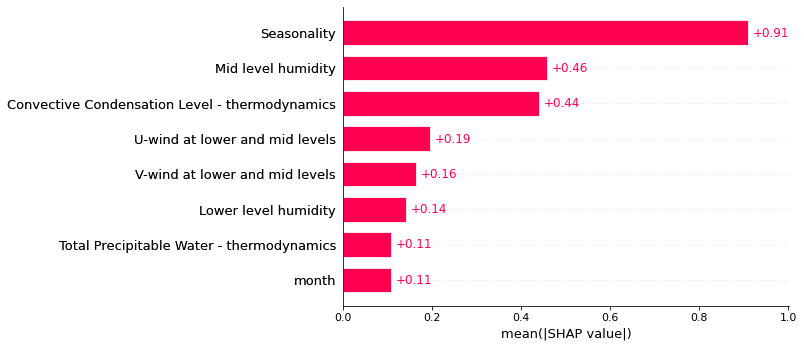

In [13]:
shap.plots.bar(shap_values, max_display=10) 


The above bar graph shows feature importance. As you can see seasonality has given most importance followed by mid level humidity. 

**Heatmap plot**

The variable importance is shown in descending order in the Y-axis, with the bars resembling the bars in the bar chart. The f(x) curve on the top is the model predictions for the instances. The SHAP first runs a hierarchical clustering on the instances to cluster them, then orders the instances (using shap.order.hclust) on the X-axis. The center of the 2D heatmap is the base_value (using .base_value), which is the mean prediction for all instances.

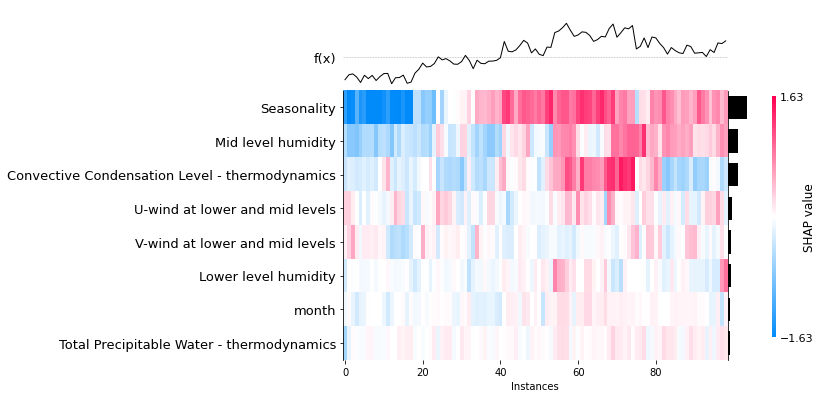

In [14]:
shap.plots.heatmap(shap_values[1:100])

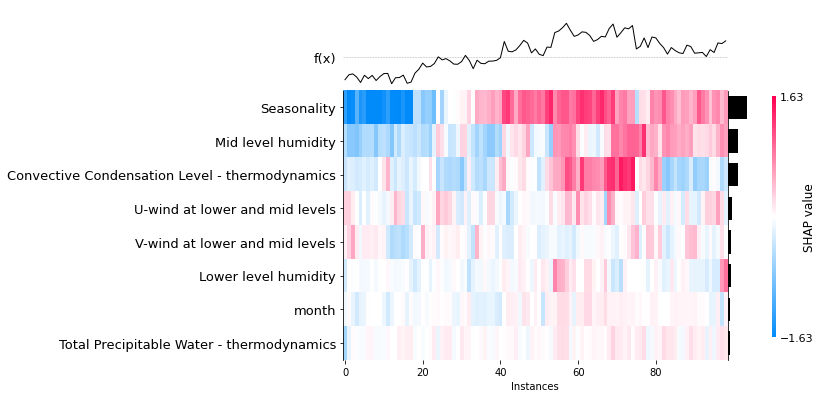

In [15]:
shap.plots.heatmap(shap_values[1:100])

This heat map shows high predictions(high values in *f*(x) values in dark pink/red color which is associated with seasonality and mid level humidity.The heatmap is for first 100 observations

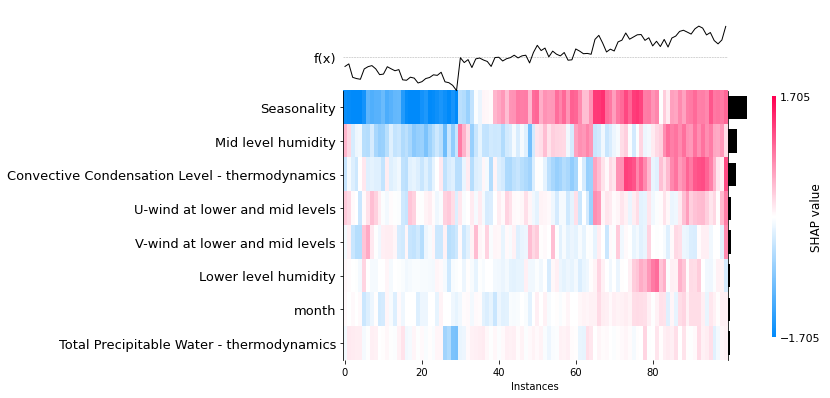

In [16]:
shap.plots.heatmap(shap_values[200:300])

**The waterfall plot for an individual case**

A waterfall plot shows why a case receives its prediction given its variable values. You start with the bottom of a waterfall plot and add (red) or subtract (blue) the values to get to the final prediction. The graph below shows the prediction for the first observation in X_test. It starts with the base value in the bottom, which is the average of all observations. The values next to the variable names are their values.

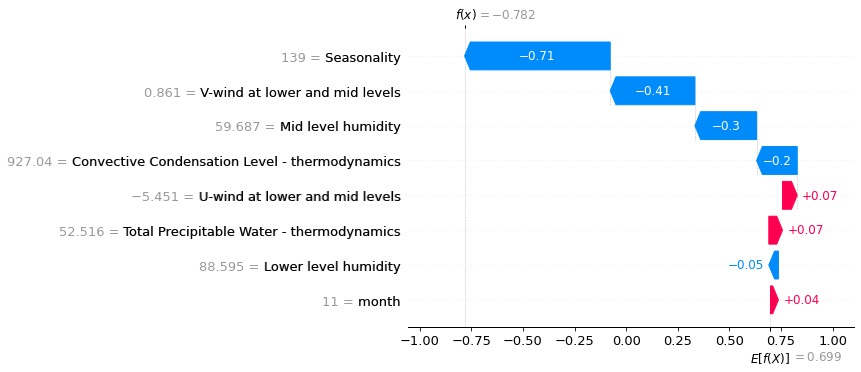

In [17]:
# SHAP values on X_test for prediction
shap.plots.waterfall(shap_values[0]) # For the first observation (September month)

The above graph shows the prediction for the first observation in X_test. f(x) ie model output value on top and E(f(x)) at the bottom is expected value from model output. 


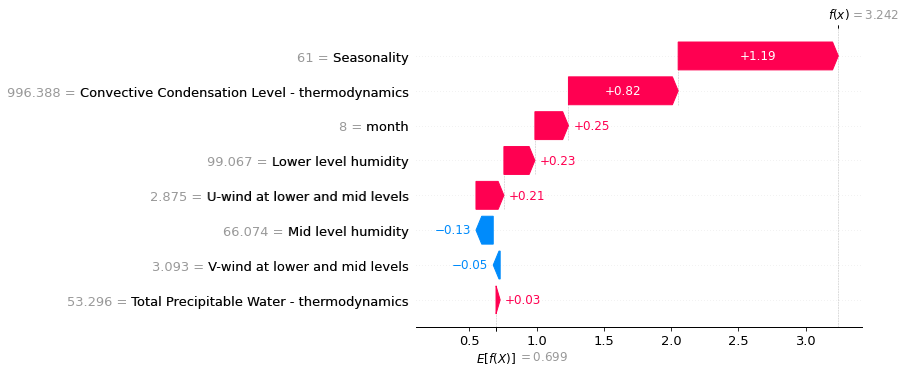

In [18]:
shap.plots.waterfall(shap_values[1]) # For the second observation which is November

**The bar plot for an individual case**

Compared with the waterfall plot, the bar plot centers at zero and shows the contributions of variables. 

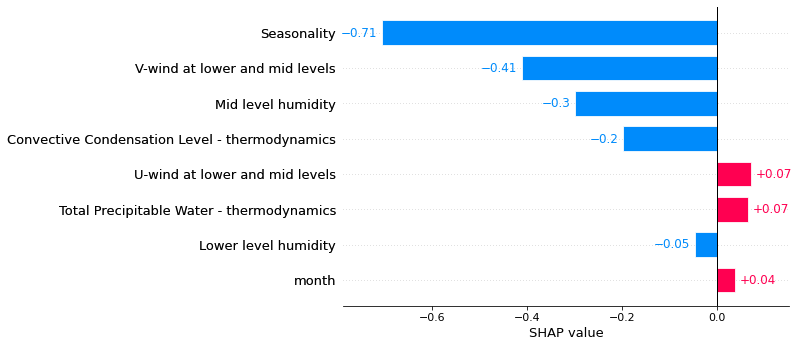

In [19]:
shap.plots.bar(shap_values[0]) # For the first observation

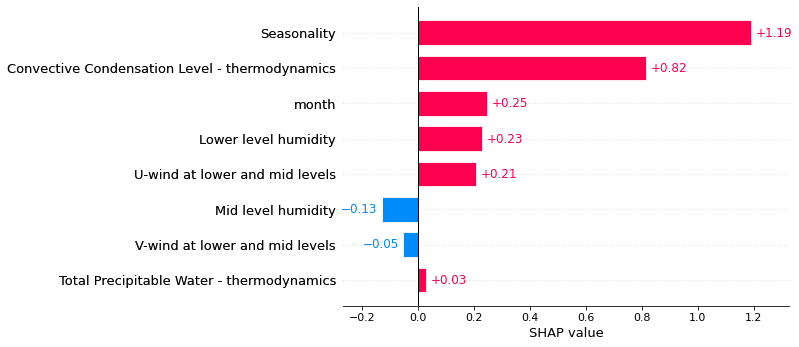

In [20]:
shap.plots.bar(shap_values[1]) # For the second observation

**The force plot for an individual case**

The blue forces pushing the predictions to the left, and the red forces to the right. 


In [21]:
# force plot for first observation
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.initjs()
def p(j):
    return(shap.force_plot(explainer.expected_value, shap_values[j,:], X_test.iloc[j,:]))
p(0)

**The decision plots**

The expected value is  0.6988015


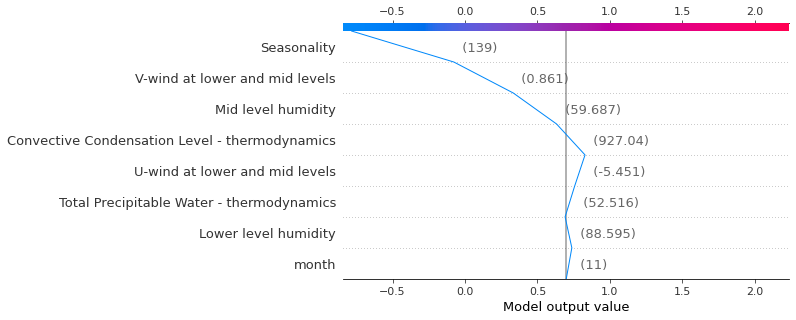

In [22]:
expected_value = explainer.expected_value
print("The expected value is ", expected_value)
shap_values = explainer.shap_values(X_test)[0]
shap.decision_plot(expected_value, shap_values, X_test)

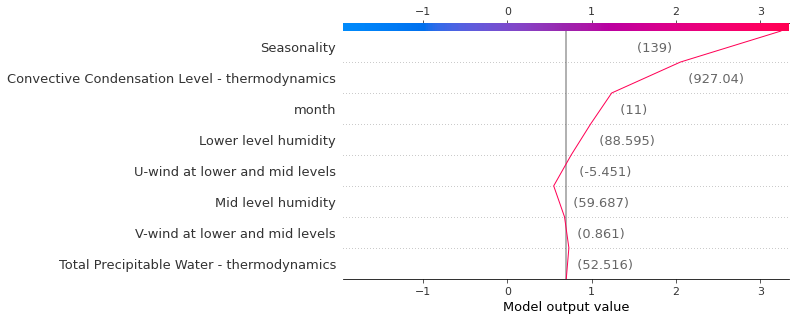

In [23]:
shap_values = explainer.shap_values(X_test)[1]
shap.decision_plot(expected_value, shap_values, X_test)